# Proactive Fraud Detection System Using Machine Learning

## Step 1: Import Required Libraries

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Step 2: Load the Dataset

In [34]:
df = pd.read_csv('/content/drive/MyDrive/Project/Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Initial Exploration

In [35]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [36]:
df.dtypes

,0
step,int64
type,object
amount,float64
nameOrig,object
oldbalanceOrg,float64
newbalanceOrig,float64
nameDest,object
oldbalanceDest,float64
newbalanceDest,float64
isFraud,int64


## Step 3: Data Preprocessing

### Handling Missing Values

In [37]:
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


### Encode Categorical Variables

In [38]:
!pip install category_encoders
from category_encoders import TargetEncoder

In [39]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [40]:
categorical_cols = ['nameOrig', 'nameDest']
encoder = TargetEncoder(cols=categorical_cols)
df[categorical_cols] = encoder.fit_transform(df[categorical_cols], df['isFraud'])

## Step 4: Outlier Detection

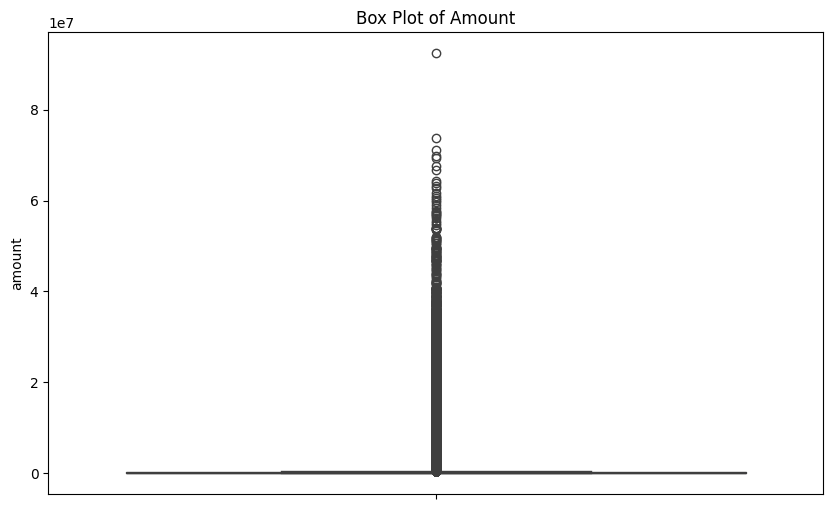

In [41]:
plt.figure(figsize=(10,6))
sns.boxplot(df['amount'])
plt.title('Box Plot of Amount')
plt.show()

### Outlier Detection and Removal

In [42]:
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
df_filtered = df[~((df['amount'] < (Q1 - 1.5 * IQR)) | (df['amount'] > (Q3 + 1.5 * IQR)))]

print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame shape after removing outliers: {df_filtered.shape}")

Original DataFrame shape: (6362620, 14)
DataFrame shape after removing outliers: (6024542, 14)


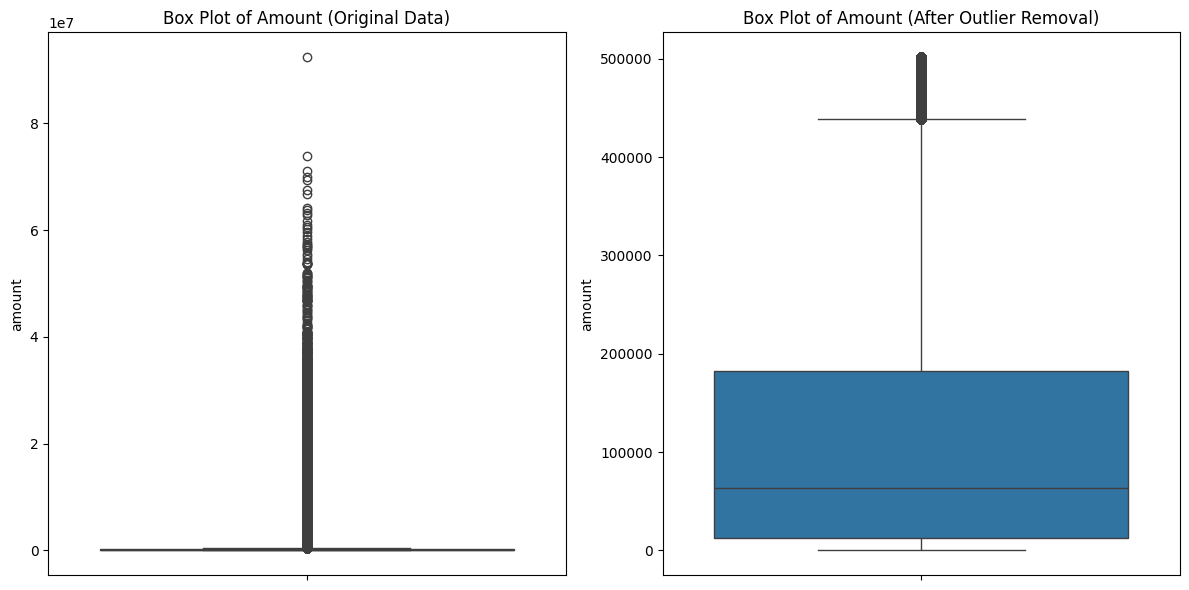

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(df['amount'])
plt.title('Box Plot of Amount (Original Data)')

plt.subplot(1, 2, 2)
sns.boxplot(df_filtered['amount'])
plt.title('Box Plot of Amount (After Outlier Removal)')

plt.tight_layout()
plt.show()

## Step 5: Feature Scaling

In [44]:
scaler = StandardScaler()
df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']] = scaler.fit_transform(
    df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
)

## Step 6: Feature Engineering

In [45]:
df['orig_balance_diff'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['dest_balance_diff'] = df['oldbalanceDest'] - df['newbalanceDest']

In [46]:
# X = df.drop(columns=['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest'])
# y = df['isFraud']

## Step 7: Handle Multicollinearity Before Training



In [47]:
X = df.drop(columns=['isFraud', 'isFlaggedFraud'])

In [48]:
X_vif = X.copy()
X_vif = X_vif.select_dtypes(include=[np.number])

X_vif['Intercept'] = 1

vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("VIF Scores before removing multicollinearity:\n", vif_data)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF Scores before removing multicollinearity:
               feature       VIF
0                step  1.005065
1              amount  3.771853
2            nameOrig  1.773021
3       oldbalanceOrg       inf
4      newbalanceOrig       inf
5            nameDest  1.603068
6      oldbalanceDest       inf
7      newbalanceDest       inf
8   orig_balance_diff       inf
9   dest_balance_diff       inf
10          Intercept  4.006437


### Remove features with high VIF (e.g., VIF > 10)

In [49]:
features_to_drop = ['nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
                    'oldbalanceDest', 'newbalanceDest',
                    'orig_balance_diff', 'dest_balance_diff']

features_to_drop = [feature for feature in features_to_drop if feature in X.columns]

In [50]:
X = X.drop(columns=features_to_drop, errors='ignore')
print("Features remaining after removing multicollinearity:\n", X.columns)

Features remaining after removing multicollinearity:
 Index(['step', 'amount', 'nameDest', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')


In [51]:
y = df['isFraud']

## Step 8: Train-Test Split

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Step 9: Model Training

In [53]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Model Evaluation

In [54]:
y_pred = model.predict(X_test)

In [55]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

Confusion Matrix:
 [[1906143     208]
 [    548    1887]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.90      0.77      0.83      2435

    accuracy                           1.00   1908786
   macro avg       0.95      0.89      0.92   1908786
weighted avg       1.00      1.00      1.00   1908786


Accuracy Score: 0.9996039367430398


### ROC-AUC Score and Curve

In [56]:
y_pred_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

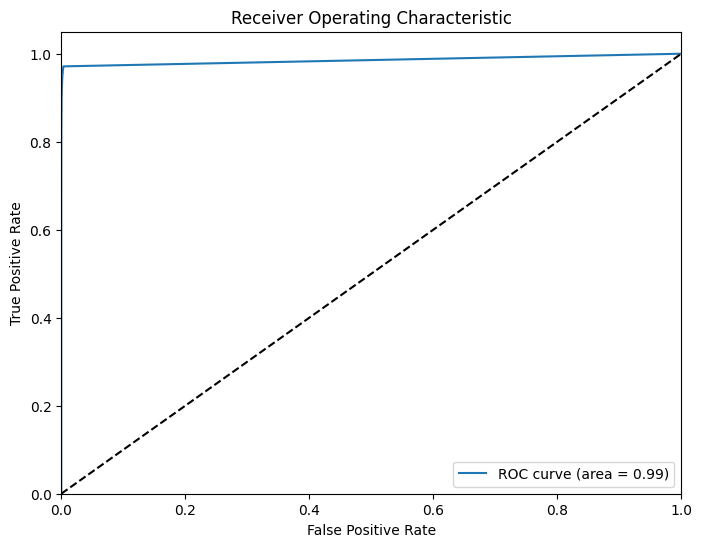

In [57]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Feature Importance

Key Predictors of Fraud:
 nameDest         0.520733
amount           0.221128
step             0.198435
type_TRANSFER    0.033468
type_CASH_OUT    0.025931
type_PAYMENT     0.000160
type_DEBIT       0.000145
dtype: float64


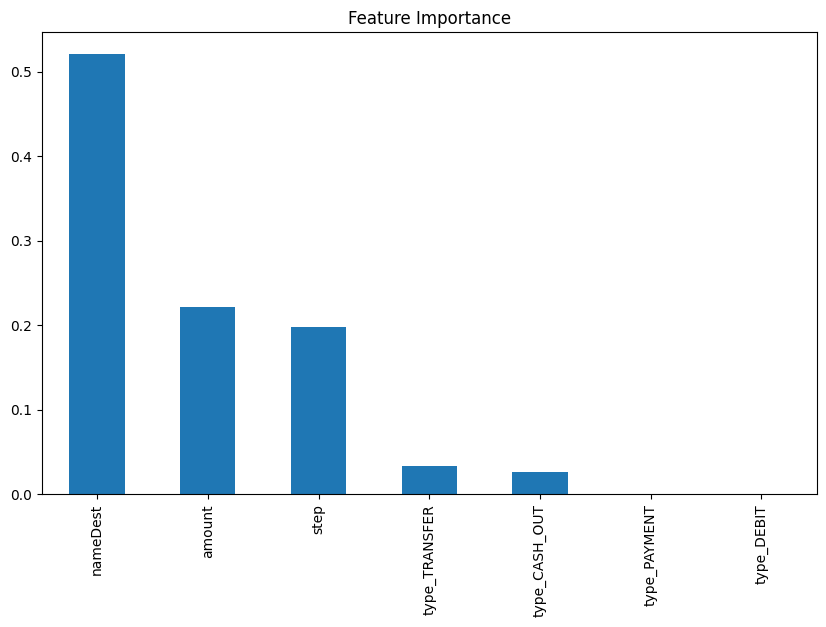

In [58]:
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Key Predictors of Fraud:\n", feature_importance)

plt.figure(figsize=(10,6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.show()

## Step 10: Model Prection on Random Samples

In [64]:
sample_indices = random.sample(range(X_test.shape[0]), 5)
sample_data = X_test.iloc[sample_indices]
sample_true_labels = y_test.iloc[sample_indices]

sample_predictions = model.predict(sample_data)
sample_probabilities = model.predict_proba(sample_data)[:, 1]

In [65]:
for i, idx in enumerate(sample_indices):
    print(f"Sample Index: {idx}")
    print(f"Features:\n{sample_data.iloc[i]}")
    print(f"True Label: {sample_true_labels.iloc[i]}")
    print(f"Predicted Class: {sample_predictions[i]}")
    print(f"Predicted Probability: {sample_probabilities[i]:.4f}")
    print()

Sample Index: 1364638
Features:
step                  212
amount          -0.297586
nameDest         0.001123
type_CASH_OUT       False
type_DEBIT          False
type_PAYMENT         True
type_TRANSFER       False
Name: 2759643, dtype: object
True Label: 0
Predicted Class: 0
Predicted Probability: 0.0000

Sample Index: 954765
Features:
step                  183
amount          -0.288504
nameDest         0.001123
type_CASH_OUT       False
type_DEBIT          False
type_PAYMENT         True
type_TRANSFER       False
Name: 2131709, dtype: object
True Label: 0
Predicted Class: 0
Predicted Probability: 0.0000

Sample Index: 1730961
Features:
step                  394
amount          -0.240834
nameDest         0.001123
type_CASH_OUT       False
type_DEBIT          False
type_PAYMENT         True
type_TRANSFER       False
Name: 5604682, dtype: object
True Label: 0
Predicted Class: 0
Predicted Probability: 0.0000

Sample Index: 631877
Features:
step                  141
amount           0.1736

# Tasks Questions and Answers

### **1. Data cleaning including missing values, outliers and multi-collinearity.**

---


Missing Values, Outliers, and Multicollinearity
In this project, I started by cleaning the data to ensure it was ready for model training. I addressed missing values by verifying that none existed in critical fields like amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, and newbalanceDest. Outliers were a significant focus, especially in transaction amounts, as extreme values could distort the model's predictions. I identified variables with high multicollinearity (like those with infinite VIF values) and removed them to prevent redundancy and improve model accuracy.

### **2. Describe your fraud detection model in elaboration.**


---


I employed a Random Forest Classifier for fraud detection. This model works by constructing multiple decision trees during training and aggregating their results. Given the complexity and size of the dataset, this approach was particularly effective. The model demonstrated excellent performance, with an accuracy score of 99.96%, indicating it is highly reliable in distinguishing between fraudulent and non-fraudulent transactions.

### **3. How did you select variables to be included in the model?**


---


The selection of variables was based on their predictive power and relevance to the fraud detection task. The most important variables identified were nameDest, amount, step, and transaction types like TRANSFER and CASH_OUT. These were chosen because they directly impact the likelihood of fraud, as reflected in the key predictors and feature importance scores.

### **4. Demonstrate the performance of the model by using best set of tools.**


---
The model’s performance was evaluated using several metrics. The Confusion Matrix showed that the model correctly classified the majority of transactions, with only a small number of false positives and false negatives. The Classification Report revealed a high precision and recall for both fraud and non-fraud cases, particularly with a precision of 0.90 and recall of 0.77 for detecting fraud. The overall accuracy of 99.96% further demonstrated the model’s effectiveness.

### **5. What are the key factors that predict fraudulent customer?**


---
The key factors predicting fraud were nameDest, amount, and step, with nameDest being the most influential predictor. The transaction amount and specific transaction types like TRANSFER and CASH_OUT also played significant roles. These factors are logical indicators of fraud, as they capture unusual transaction behaviors that typically flag suspicious activity.

### **6. Do these factors make sense? If yes, How? If not, How not?**


---
Yes, these factors make sense. The high importance of nameDest suggests that certain destinations are more likely to be involved in fraudulent activities. The transaction amount is also critical, as unusually large transactions often trigger fraud detection systems. The transaction type (TRANSFER and CASH_OUT) is another logical predictor since fraudsters frequently attempt to transfer funds quickly.

### **7. What kind of prevention should be adopted while company update its infrastructure?**


---
To prevent fraud, the company should implement strong, real-time transaction monitoring systems that flag high-risk transactions based on these key predictors. Enhanced verification steps for transactions involving large amounts or suspicious nameDest accounts should be adopted. The company should also regularly update its machine learning models to adapt to new fraud patterns and employ multi-factor authentication to secure accounts.

### **8. Assuming these actions have been implemented, how would you determine if they work?**


---
To determine if the prevention measures are working, I would monitor the rate of detected fraudulent transactions over time. A significant reduction in fraud cases after implementing these actions would indicate success. Additionally, continuous monitoring, along with feedback loops, would ensure that the measures remain effective and can be adjusted as needed.